# Imports

In [1]:
## imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import os
root = os.path.expanduser('~')

# Data Load

In [2]:
pc_flag = 'pro'

sentences = pd.\
read_csv(f'~/Desktop/dm_project/data/prepx/{pc_flag}_doc_sampled_6.csv')

sentences.shape

(33624, 15)

In [3]:
# display(sentences)
sents = sentences.Px_Texts.values
print(len(sents))
count = 0
for sent in sents[:5]:
    if (len(sent.split()) <= 0) :
        count += 1
print(count)
        
    


33624
0


# Tokenization

In [4]:
df = sentences.copy()

data_px = [sents.split() for sents in df.Px_Texts.values]
print(len(data_px))

33624


# Build Dictionary

In [5]:
# Create Dictionary
id2word = corpora.Dictionary(data_px) ##dictionary
print(len(id2word))
print(id2word)

# Create Corpus
texts = data_px 

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]  ##corpus

# View
print(corpus[:5])

14878
Dictionary(14878 unique tokens: ['benefit', 'benefit_discount', 'break', 'discount', 'discount_break']...)
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)], [(2, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)], [(2, 1), (13, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)], [(6, 1), (13, 1), (17, 1), (19, 1), (21, 1)], [(19, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1)]]


# LDA

In [9]:
def lda_viz(num_topics): 

    # %%time
    # Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
    num_topics = num_topics
    mallet_path = root + '/Downloads/mallet-2.0.8/bin/mallet' # update this path
    ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, random_seed=42)


    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=ldamallet, texts=data_px, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)


    ##mallet model to lda model conversion
    optimal_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

    # %%time
    # Visualize the topics
    pyLDAvis.enable_notebook()
    # vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, mds='tsne')
    vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
    return vis, optimal_model
    # pyLDAvis.show(vis)

In [7]:
# viz = lda_viz(22)
# viz

# Finding Optimal Model

In [119]:
#parameter tuning (finding the best model)
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    mallet_path = root + '/Downloads/mallet-2.0.8/bin/mallet' # update this path
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, 
                                                  random_seed=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [120]:
#  Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_px, start=4, limit=21, step=2)

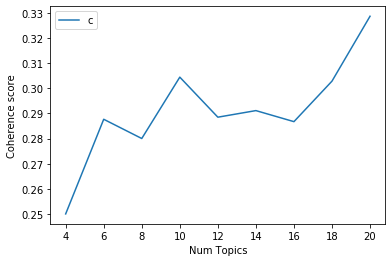

In [123]:
# Show graph
limit=21; start=4; step=2;

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.xticks(range(4, 21, 2))
plt.savefig(root + '/Desktop/paper_fig/lda/con/coherence.png')
plt.show()

In [124]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 4  has Coherence Value of 0.2501
Num Topics = 6  has Coherence Value of 0.2877
Num Topics = 8  has Coherence Value of 0.28
Num Topics = 10  has Coherence Value of 0.3044
Num Topics = 12  has Coherence Value of 0.2885
Num Topics = 14  has Coherence Value of 0.2911
Num Topics = 16  has Coherence Value of 0.2867
Num Topics = 18  has Coherence Value of 0.3028
Num Topics = 20  has Coherence Value of 0.3286


# Optimal Model Visualization

In [10]:
num_topics = 16
vis, optimal_model = lda_viz(num_topics)
vis



Coherence Score:  0.3491513611319391


/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
9     -0.045162  0.181523       1        1  6.356780
15    -0.108535 -0.117774       2        1  6.318156
14    -0.145847 -0.098281       3        1  6.278810
10    -0.207141 -0.279654       4        1  6.268487
4      0.319662 -0.103235       5        1  6.268268
1      0.313160 -0.102403       6        1  6.256150
5     -0.160830 -0.230248       7        1  6.249627
8     -0.035320  0.095493       8        1  6.249536
12    -0.055179  0.188635       9        1  6.238596
11    -0.079587  0.096506      10        1  6.236920
3      0.124264  0.001749      11        1  6.234287
2     -0.024428  0.100508      12        1  6.224092
6     -0.042222  0.106894      13        1  6.223819
0     -0.020839  0.100663      14        1  6.222295
13     0.223465 -0.054461      15        1  6.188410
7     -0.055462  0.114084      16        1  6.185768, topic_info=        Term         Freq        Total Category  logprob  loglift
0    benefit  8609.000000  8609.000000  Default  30.0000  30.0000
30       pay  5129.000000  5129.000000  Default  29.0000  29.0000
36      free  4910.000000  4910.000000  Default  28.0000  28.0000
19     lunch  3930.000000  3930.000000  Default  27.0000  27.0000
143    peopl  2942.000000  2942.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
123     love   172.026816   215.647065  Topic16  -4.3434   2.5569
182    offic   182.266508   316.554146  Topic16  -4.2856   2.2309
186    build   132.092020   351.973072  Topic16  -4.6076   1.8029
443    locat   116.732482   342.598803  Topic16  -4.7312   1.7062
567   travel    94.205161   244.303977  Topic16  -4.9456   1.8300

[1108 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
67        3  1.007739          15_min_break
126       3  0.997519        15_minut_break
68        3  1.002383          1_hour_lunch
1192      4  0.978163  401_tuition_reimburs
491      10  0.999988                  abil
...     ...       ...                   ...
974      13  0.973996                 world
6762      4  0.978163         ye_free_lunch
622       5  0.010911                yearli
622       8  0.992907                yearli
3867     16  0.976592                 youll

[1285 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 16, 15, 11, 5, 2, 6, 9, 13, 12, 4, 3, 7, 1, 14, 8])

In [11]:
# pyLDAvis.save_html(vis, root + '/Desktop/paper_fig/lda/pro/lda_viz.html')

## Topic Composition

In [12]:
# Print the topics
model_topics = optimal_model.show_topics(formatted=True, num_topics=num_topics)
# pprint(optimal_model.print_topics(num_words=10))
pprint(model_topics)

[(0,
  '0.158*"environ" + 0.080*"friendli" + 0.075*"fun" + 0.045*"fast" + '
  '0.042*"worker" + 0.041*"pace" + 0.035*"fast_pace" + 0.030*"staff" + '
  '0.030*"co_worker" + 0.029*"stock"'),
 (1,
  '0.383*"pay" + 0.204*"benefit" + 0.085*"pay_benefit" + 0.068*"decent" + '
  '0.035*"benefit_pay" + 0.033*"decent_pay" + 0.010*"decent_benefit" + '
  '0.008*"amaz" + 0.006*"benefit_decent" + 0.006*"averag"'),
 (2,
  '0.096*"team" + 0.084*"balanc" + 0.063*"cultur" + 0.054*"compens" + '
  '0.050*"life" + 0.042*"worklif" + 0.040*"worklif_balanc" + '
  '0.037*"life_balanc" + 0.034*"support" + 0.022*"divers"'),
 (3,
  '0.127*"opportun" + 0.080*"train" + 0.078*"advanc" + 0.031*"growth" + '
  '0.029*"career" + 0.029*"benefit" + 0.025*"posit" + 0.022*"develop" + '
  '0.022*"secur" + 0.021*"relax"'),
 (4,
  '0.343*"benefit" + 0.100*"excel" + 0.046*"salari" + 0.030*"excel_benefit" + '
  '0.028*"packag" + 0.026*"medic" + 0.025*"competit" + 0.023*"plan" + '
  '0.018*"start" + 0.018*"benefit_packag"'),
 (5,

In [14]:
## Dominant Topic in each documents

def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_px):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_px)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             8.0              0.1050   
1            1             0.0              0.1208   
2            2            14.0              0.1514   
3            3            14.0              0.1022   
4            4             8.0              0.0914   
5            5             3.0              0.0915   
6            6             5.0              0.1167   
7            7            14.0              0.1072   
8            8            14.0              0.1544   
9            9             9.0              0.1208   

                                            Keywords  \
0  employe, discount, product, bonus, program, re...   
1  environ, friendli, fun, fast, worker, pace, fa...   
2  hour, break, lunch, hour_lunch, lunch_break, s...   
3  hour, break, lunch, hour_lunch, lunch_break, s...   
4  employe, discount, product, bonus, program, re...   
5  opportun, train, advanc, growth, career, benef...   
6  free, food, free_food, drink, bonu, incent, ev...   
7  hour, break, lunch, hour_lunch, lunch_break, s...   
8  hour, break, lunch, hour_lunch, lunch_break, s...   
9  time, paid, vacat, insur, holiday, day, pto, p...   

                                                Text  
0  [benefit, break, discount, reason, schedul, ti...  
1  [amaz, break, cowork, fast, fun, hour, pace, f...  
2  [break, enforc, hour, lunch, hour_lunch, lunch...  
3          [hour, lunch, schedul, usual, hour_lunch]  
4  [bonu, friday, lunch, quarterli, lunch_quarter...  
5               [code, dress, lax, pay, rais, start]  
6  [discount, food, free, time, discount_free, fr...  
7  [avail, benefit, decent, easi, hour, lunch, pr...  
8  [break, hour, lunch, hour_lunch, lunch_break, ...  
9  [benefit, insur, lunch, minut, paid, vacat, lu...

In [15]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.2187   
1        0.0              0.1904   
2        0.0              0.1894   
3        0.0              0.1876   
4        0.0              0.1868   

                                            Keywords  \
0  environ, friendli, fun, fast, worker, pace, fa...   
1  environ, friendli, fun, fast, worker, pace, fa...   
2  environ, friendli, fun, fast, worker, pace, fa...   
3  environ, friendli, fun, fast, worker, pace, fa...   
4  environ, friendli, fun, fast, worker, pace, fa...   

                                                Text  
0  [environ, fast, friendli, pace, staff, environ...  
1  [easi, fast, friendli, pace, pay, staff, fast_...  
2  [employe, environ, fast, friendli, fun, rais, ...  
3  [environ, fast, fun, knowledg, pace, staff, fa...  
4  [environ, fast, pace, pay, fast_pace, pace_env...

In [122]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts().sort_index()
# display(topic_counts)

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4).sort_index()
# display(topic_contribution)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates().sort_values(by='Dominant_Topic').set_index('Dominant_Topic')
# display(topic_num_keywords)

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
pd.set_option('display.max_colwidth', -1)
df_dominant_topics

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


Topic_Keywords  \
0.0   environ, friendli, fun, fast, worker, pace, fast_pace, staff, co_worker, stock                             
1.0   pay, benefit, pay_benefit, decent, benefit_pay, decent_pay, decent_benefit, amaz, benefit_decent, averag   
2.0   team, balanc, cultur, compens, life, worklif, worklif_balanc, life_balanc, support, divers                 
3.0   opportun, train, advanc, growth, career, benefit, posit, develop, secur, relax                             
4.0   benefit, excel, salari, excel_benefit, packag, medic, competit, plan, start, benefit_packag                
5.0   free, food, free_food, drink, bonu, incent, event, perk, snack, parti                                      
6.0   lot, learn, experi, busi, overtim, skill, avail, technolog, money, knowledg                                
7.0   peopl, nice, meet, awesom, differ, meet_peopl, enjoy, nice_peopl, offic, love                              
8.0   employe, discount, product, bonus, program, reward, store, employe_discount, offer, recognit               
9.0   time, paid, vacat, insur, holiday, day, pto, paid_time, vacat_time, health_insur                           
10.0  free, lunch, free_lunch, sometim, tuition, reimburs, activ, build, occasion, meal                          
11.0  flexibl, schedul, home, flexibl_schedul, flexibl_hour, hour, abil, close, weekli, locat                    
12.0  custom, day, servic, provid, educ, phone, cabl, week, abl, custom_servic                                   
13.0  manag, cowork, benefit, healthcar, atmospher, famili, wage, union, fair, easi                              
14.0  hour, break, lunch, hour_lunch, lunch_break, shift, minut, rais, 1_hour_lunch, minut_break                 
15.0  health, care, coffe, gym, cafeteria, free, health_benefit, health_care, free_coffe, site                   

      Num_Documents  Perc_Documents  
0.0   2247           0.0668          
1.0   2036           0.0606          
2.0   2343           0.0697          
3.0   2157           0.0642          
4.0   1663           0.0495          
5.0   1970           0.0586          
6.0   2182           0.0649          
7.0   2265           0.0674          
8.0   1938           0.0576          
9.0   2325           0.0691          
10.0  2115           0.0629          
11.0  2380           0.0708          
12.0  1919           0.0571          
13.0  1911           0.0568          
14.0  1972           0.0586          
15.0  2201           0.0655

In [16]:
df_dominant_topic.head()

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             8.0              0.1050   
1            1             0.0              0.1208   
2            2            14.0              0.1514   
3            3            14.0              0.1022   
4            4             8.0              0.0914   

                                            Keywords  \
0  employe, discount, product, bonus, program, re...   
1  environ, friendli, fun, fast, worker, pace, fa...   
2  hour, break, lunch, hour_lunch, lunch_break, s...   
3  hour, break, lunch, hour_lunch, lunch_break, s...   
4  employe, discount, product, bonus, program, re...   

                                                Text  
0  [benefit, break, discount, reason, schedul, ti...  
1  [amaz, break, cowork, fast, fun, hour, pace, f...  
2  [break, enforc, hour, lunch, hour_lunch, lunch...  
3          [hour, lunch, schedul, usual, hour_lunch]  
4  [bonu, friday, lunch, quarterli, lunch_quarter...

### Document - Word Count Distribution

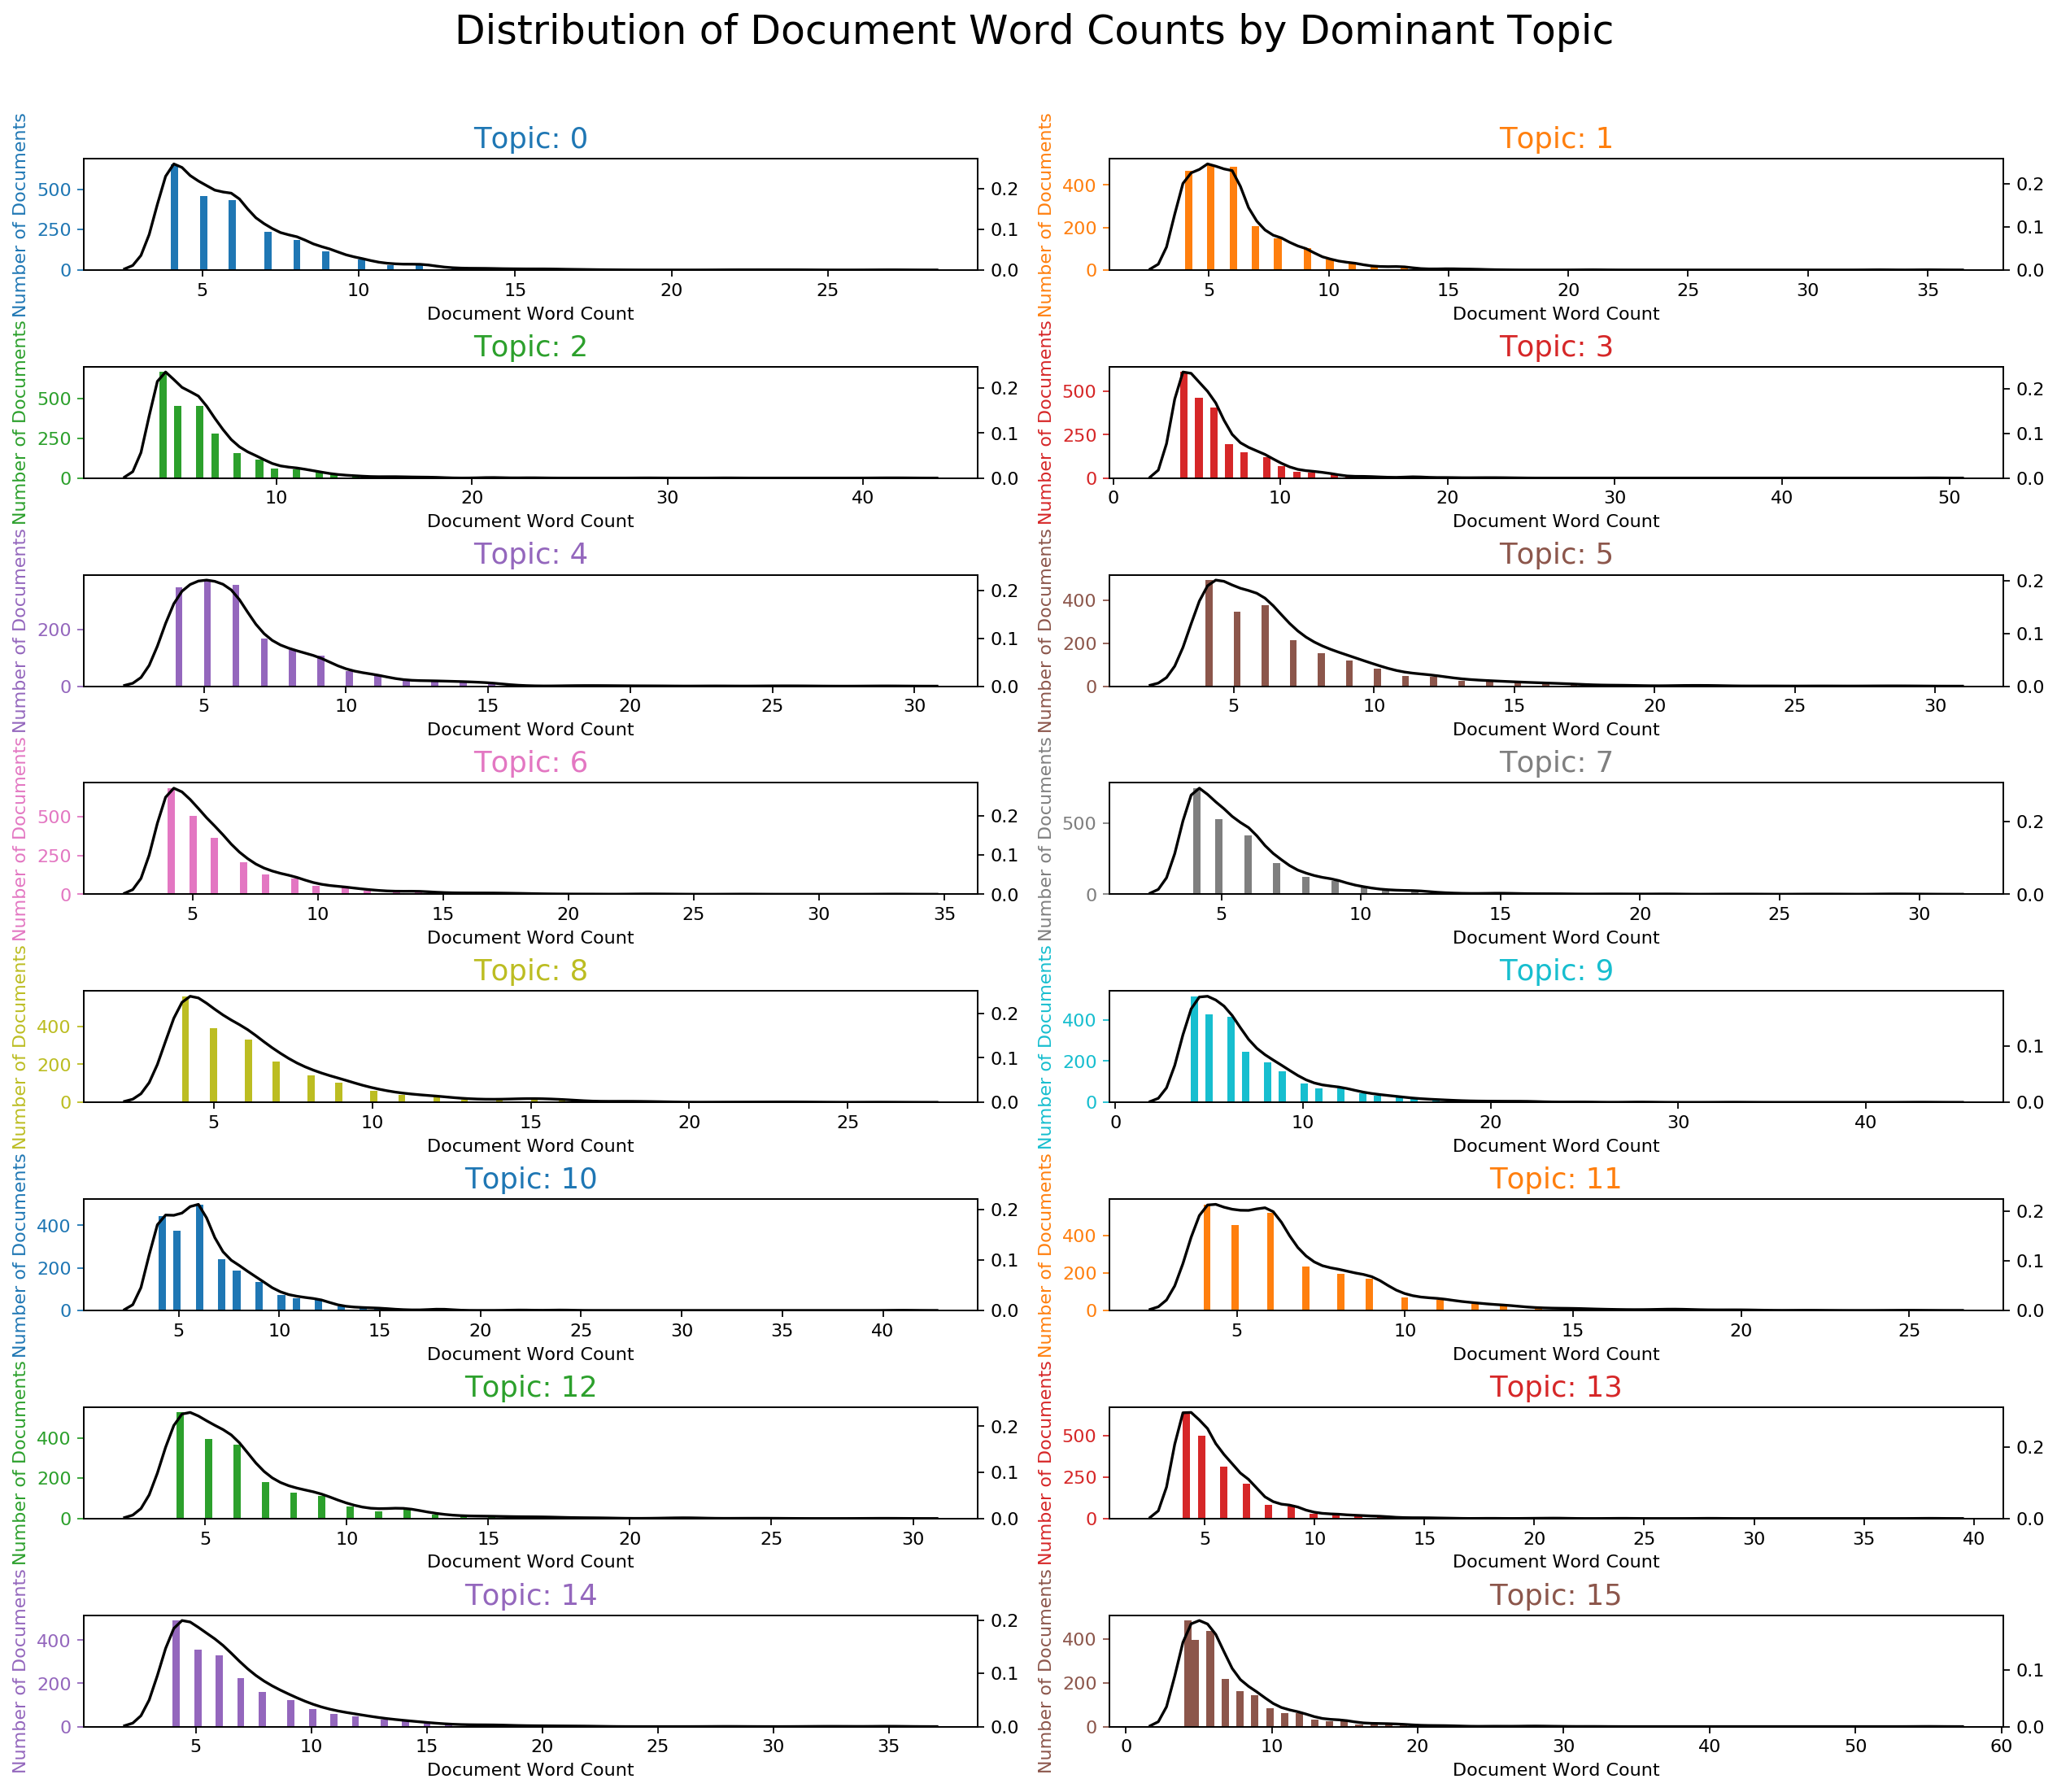

In [18]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(int((optimal_model.num_topics+1)/2),2,figsize=(16,14), dpi=160)

for i, ax in enumerate(axes.flatten()):   

    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins=100, color=cols[i%10])
    ax.tick_params(axis='y', labelcolor=cols[i%10], color=cols[i%10])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i%10])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i%10]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
# plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

# Bar Plot

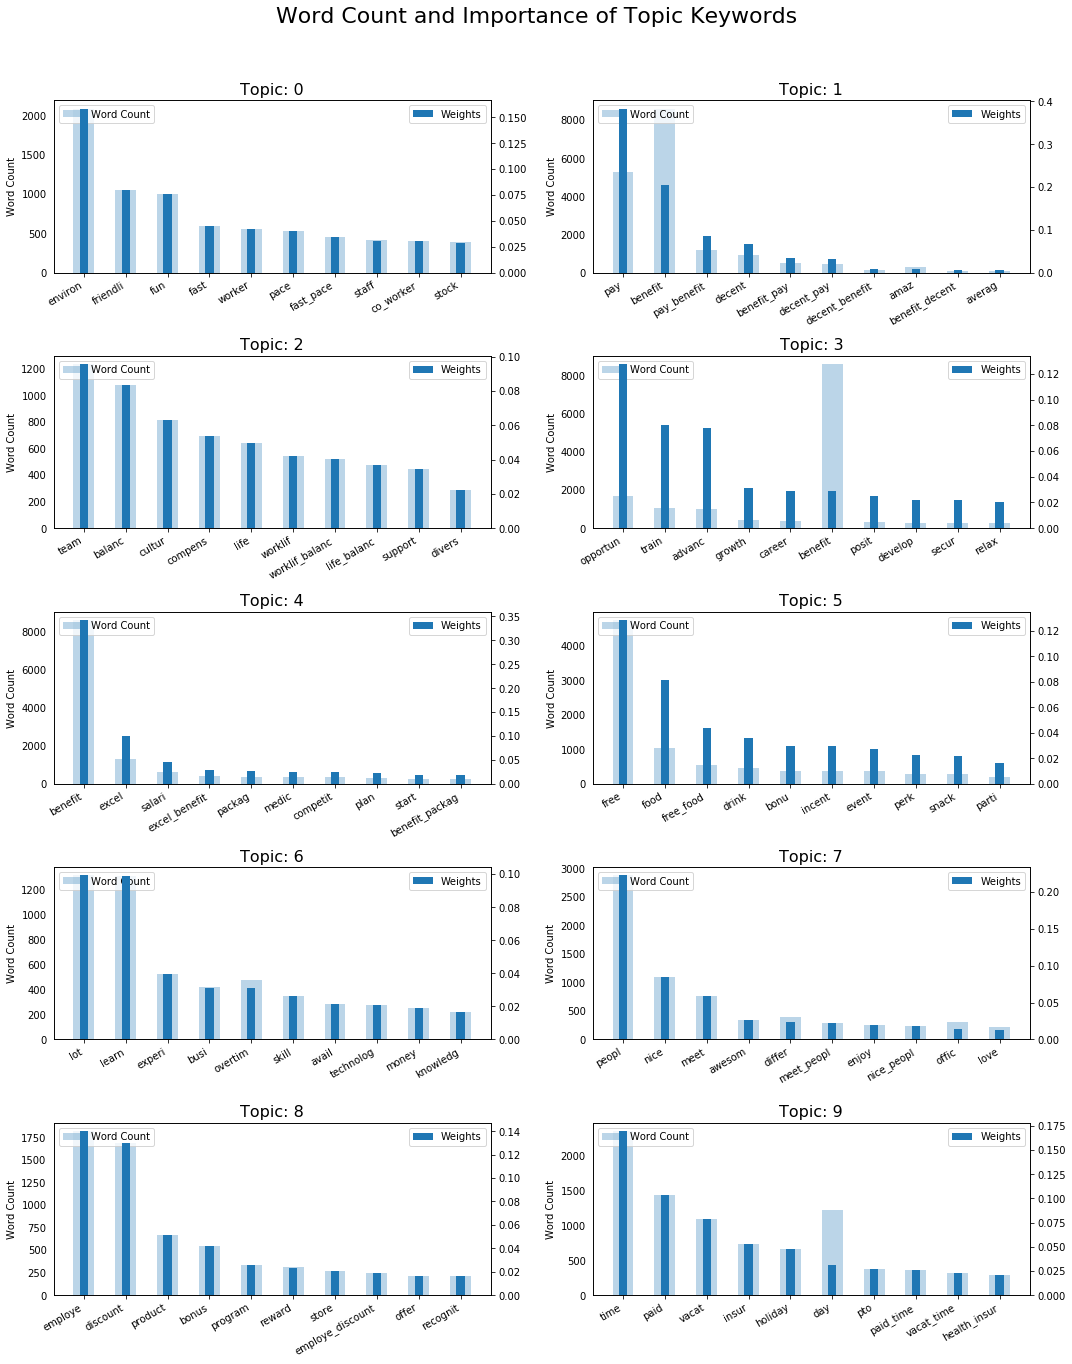

In [19]:
from collections import Counter

topics = optimal_model.show_topics(formatted=False, num_topics=num_topics)
data_flat = [w for w_list in data_px for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])   

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(15,18))
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[0], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[0], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color='black')
#     ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color='black', fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)  

plt.show()

# Stacked Bar Chart

In [20]:
df1 = df.copy()

In [21]:
df = pd.DataFrame()
for i in range(num_topics):
    df.insert(i, f"{i+1}", np.round(df1.loc[df1.topic_id==i, :]["importance"].to_numpy(), 2), True) 
# df.append(df.sum(numeric_only=True), ignore_index=True)
remain = 1-df.sum().to_numpy()
print(remain)
df.loc[len(df)] = remain
df = df.T
df

[0.44 0.17 0.49 0.54 0.33 0.56 0.59 0.51 0.51 0.42 0.33 0.44 0.68 0.44
 0.44 0.64]


0     1     2     3     4     5     6     7     8     9     10
1   0.16  0.08  0.08  0.04  0.04  0.04  0.03  0.03  0.03  0.03  0.44
2   0.38  0.20  0.08  0.07  0.03  0.03  0.01  0.01  0.01  0.01  0.17
3   0.10  0.08  0.06  0.05  0.05  0.04  0.04  0.04  0.03  0.02  0.49
4   0.13  0.08  0.08  0.03  0.03  0.03  0.02  0.02  0.02  0.02  0.54
5   0.34  0.10  0.05  0.03  0.03  0.03  0.03  0.02  0.02  0.02  0.33
6   0.13  0.08  0.04  0.04  0.03  0.03  0.03  0.02  0.02  0.02  0.56
7   0.10  0.10  0.04  0.03  0.03  0.03  0.02  0.02  0.02  0.02  0.59
8   0.22  0.08  0.06  0.03  0.02  0.02  0.02  0.02  0.01  0.01  0.51
9   0.14  0.13  0.05  0.04  0.03  0.02  0.02  0.02  0.02  0.02  0.51
10  0.17  0.10  0.08  0.05  0.05  0.03  0.03  0.03  0.02  0.02  0.42
11  0.20  0.19  0.13  0.03  0.02  0.02  0.02  0.02  0.02  0.02  0.33
12  0.15  0.10  0.08  0.05  0.05  0.04  0.03  0.02  0.02  0.02  0.44
13  0.08  0.06  0.05  0.03  0.03  0.02  0.02  0.01  0.01  0.01  0.68
14  0.17  0.12  0.07  0.05  0.04  0.03  0.02  0.02  0.02  0.02  0.44
15  0.16  0.13  0.11  0.05  0.03  0.02  0.02  0.02  0.01  0.01  0.44
16  0.10  0.04  0.04  0.03  0.03  0.03  0.03  0.02  0.02  0.02  0.64

In [23]:
imp_words1 = []

for i in range(num_topics): 
    words = df1.loc[df1.topic_id==i, :]["word"].to_list()
    words.append("others")
#     print(words)
    imp_words1.append(words)
imp_words1

[['environ',
  'friendli',
  'fun',
  'fast',
  'worker',
  'pace',
  'fast_pace',
  'staff',
  'co_worker',
  'stock',
  'others'],
 ['pay',
  'benefit',
  'pay_benefit',
  'decent',
  'benefit_pay',
  'decent_pay',
  'decent_benefit',
  'amaz',
  'benefit_decent',
  'averag',
  'others'],
 ['team',
  'balanc',
  'cultur',
  'compens',
  'life',
  'worklif',
  'worklif_balanc',
  'life_balanc',
  'support',
  'divers',
  'others'],
 ['opportun',
  'train',
  'advanc',
  'growth',
  'career',
  'benefit',
  'posit',
  'develop',
  'secur',
  'relax',
  'others'],
 ['benefit',
  'excel',
  'salari',
  'excel_benefit',
  'packag',
  'medic',
  'competit',
  'plan',
  'start',
  'benefit_packag',
  'others'],
 ['free',
  'food',
  'free_food',
  'drink',
  'bonu',
  'incent',
  'event',
  'perk',
  'snack',
  'parti',
  'others'],
 ['lot',
  'learn',
  'experi',
  'busi',
  'overtim',
  'skill',
  'avail',
  'technolog',
  'money',
  'knowledg',
  'others'],
 ['peopl',
  'nice',
  'meet',

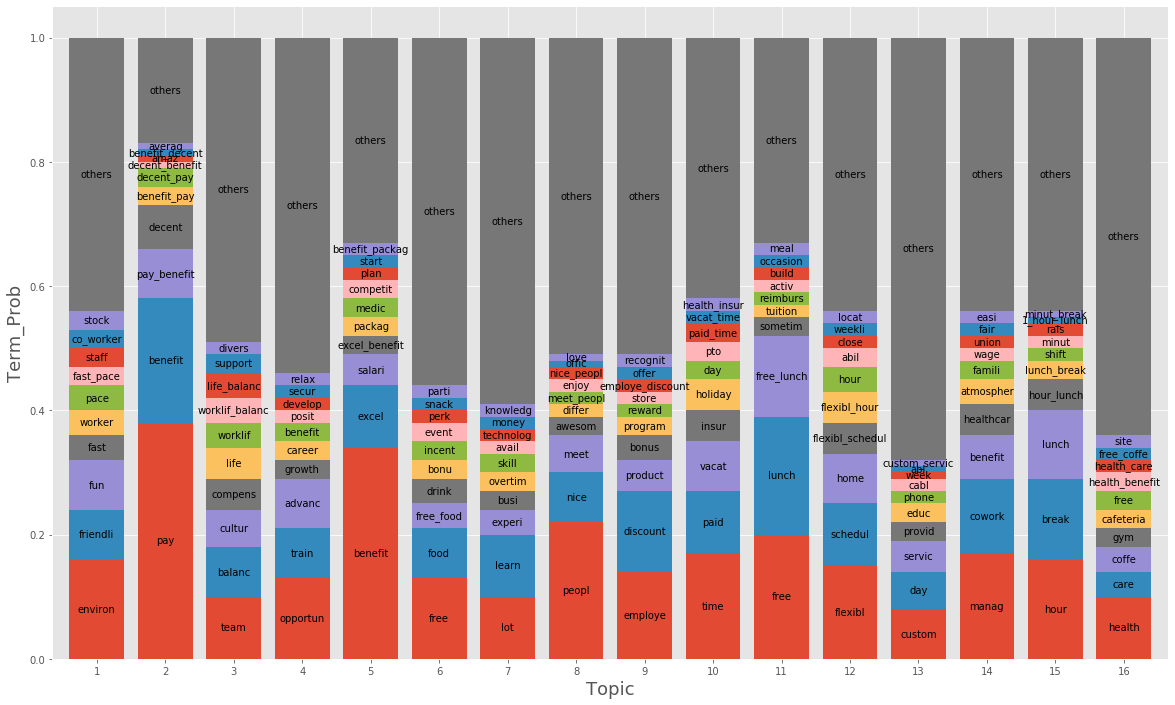

In [24]:
plt.style.use('ggplot')

ax = df.plot(stacked=True, kind='bar', figsize=(20, 12), rot='horizontal', width=.8)

# .patches is everything inside of the chart
i = 0
j = 0
for rect in ax.patches:
#     print(rect)
    # Find where everything is located
#     words = imp_words[i]
#     i += 1
    
    height = round(rect.get_height(), 2)
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The width of the bar is the data value and can used as the label
#     label_text = f'{height}'  # f'{height:.2f}' to format decimal values
    label_text = f'{imp_words1[i][j]}'
    i += 1
    if(i == num_topics): 
        i = 0
        j += 1
#     print(i, j)
    
    # ax.text(x, y, text)
    label_x = x + width - width/2 # adjust 0.2 to center the label
    label_y = y + height / 2
    ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=10)

# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) 
ax.get_legend().remove()
ax.set_ylabel("Term_Prob", fontsize=18)
ax.set_xlabel("Topic", fontsize=18)


# plt.savefig(root+'/Desktop/paper_fig/lda/pro/top-ten-words1.png')
plt.show()

# Clustering

In [25]:
from collections import OrderedDict
def get_doc_topic_dist(model=optimal_model, corpus=corpus, kwords=False):
    
    '''
    LDA transformation, for each doc only returns topics with non-zero weight
    This function makes a matrix transformation of docs in the topic space.
    '''
    top_dist =[]
    keys = []

    for d in corpus:
        tmp = {i:0 for i in range(num_topics)}
        tmp.update(dict(model[d]))
        vals = list(OrderedDict(tmp).values())
        top_dist += [np.array(vals)]
        if kwords:
            keys += [np.array(vals).argmax()]

    return np.array(top_dist), keys


def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms


In [26]:
topic_summaries = []
for i in range(num_topics):
    tmp = explore_topic(optimal_model,topic_number=i, topn=3, output=False )
    topic_summaries += [tmp[:5]]
    
topic_label = [" ".join(t) for t in topic_summaries]
print(topic_label)

['environ friendli fun', 'pay benefit pay_benefit', 'team balanc cultur', 'opportun train advanc', 'benefit excel salari', 'free food free_food', 'lot learn experi', 'peopl nice meet', 'employe discount product', 'time paid vacat', 'free lunch free_lunch', 'flexibl schedul home', 'custom day servic', 'manag cowork benefit', 'hour break lunch', 'health care coffe']


In [27]:
top_labels = dict()

for i in range(num_topics):
    top_labels[i] = topic_label[i]
    
print(top_labels)

{0: 'environ friendli fun', 1: 'pay benefit pay_benefit', 2: 'team balanc cultur', 3: 'opportun train advanc', 4: 'benefit excel salari', 5: 'free food free_food', 6: 'lot learn experi', 7: 'peopl nice meet', 8: 'employe discount product', 9: 'time paid vacat', 10: 'free lunch free_lunch', 11: 'flexibl schedul home', 12: 'custom day servic', 13: 'manag cowork benefit', 14: 'hour break lunch', 15: 'health care coffe'}


In [28]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer(
#                             analyzer='word',       
#                              min_df=10,                        # minimum reqd occurences of a word 
#                              stop_words='english',             # remove stop words
#                              lowercase=True                   # convert all words to lowercase
#                              token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

sents = [s[0] for s in sentences[['Px_Texts']].values.tolist()]
data_vectorized = vectorizer.fit_transform(sents).toarray() ##dtm

In [29]:
top_dist, lda_keys= get_doc_topic_dist(optimal_model, corpus, True)
features = vectorizer.get_feature_names()

In [30]:
print(len(top_dist))
threshold = 0.1
# threshold = 1/num_topics
_idx = np.amax(top_dist, axis=1) > threshold  # idx of doc that above the threshold

X_topic = top_dist[_idx]
print(len(X_topic))

33624
20678


In [31]:
dtm = data_vectorized

In [32]:
p_df = pd.DataFrame()
p_df['tokenz'] = np.asarray(data_px)[_idx]
p_df.head()

tokenz
0  [benefit, break, discount, reason, schedul, ti...
1  [amaz, break, cowork, fast, fun, hour, pace, f...
2  [break, enforc, hour, lunch, hour_lunch, lunch...
3          [hour, lunch, schedul, usual, hour_lunch]
4  [discount, food, free, time, discount_free, fr...

In [33]:
top_ws = []
for n in range(len(dtm)):
    inds = np.int0(np.argsort(dtm[n])[::-1][:4])
    tmp = [features[i] for i in inds]    
    top_ws += [' '.join(tmp)]


p_df['Text_Rep'] = pd.DataFrame(np.asarray(top_ws)[_idx])
p_df['clusters'] = pd.DataFrame(np.asarray(lda_keys)[_idx])
# print(p_df['clusters'].isna().sum())
# p_df['clusters'].fillna(num_topics, inplace=True)
p_df['Review_Text'] = pd.DataFrame(sentences[['Review_Text']].values[_idx])

colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5", 
    "#c7c7c8", "#bcbd23", "#dbdb8e", "#17beca", 
])

cluster_colors = dict()
for c in range(num_topics): 
    cluster_colors[c] = colormap[c]
    
p_df['colors'] = p_df['clusters'].apply(lambda l: cluster_colors[l])

In [34]:
from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2)
tsne = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')

X_tsne = tsne.fit_transform(X_topic)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20678 samples in 0.029s...
[t-SNE] Computed neighbors for 20678 samples in 8.559s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20678
[t-SNE] Computed conditional probabilities for sample 2000 / 20678
[t-SNE] Computed conditional probabilities for sample 3000 / 20678
[t-SNE] Computed conditional probabilities for sample 4000 / 20678
[t-SNE] Computed conditional probabilities for sample 5000 / 20678
[t-SNE] Computed conditional probabilities for sample 6000 / 20678
[t-SNE] Computed conditional probabilities for sample 7000 / 20678
[t-SNE] Computed conditional probabilities for sample 8000 / 20678
[t-SNE] Computed conditional probabilities for sample 9000 / 20678
[t-SNE] Computed conditional probabilities for sample 10000 / 20678
[t-SNE] Computed conditional probabilities for sample 11000 / 20678
[t-SNE] Computed conditional probabilities for sample 12000 / 20678
[t-SNE] Computed conditional probabilities for sam

In [35]:
p_df['X_tsne'] =X_tsne[:, 0]
p_df['Y_tsne'] =X_tsne[:, 1]

In [36]:
display(p_df.head())

tokenz  \
0  [benefit, break, discount, reason, schedul, ti...   
1  [amaz, break, cowork, fast, fun, hour, pace, f...   
2  [break, enforc, hour, lunch, hour_lunch, lunch...   
3          [hour, lunch, schedul, usual, hour_lunch]   
4  [discount, food, free, time, discount_free, fr...   

                                          Text_Rep  clusters  \
0   discount_break reason benefit_discount schedul         8   
1                   hour_break amaz fast_pace pace         0   
2   enforc hour_lunch_break lunch_break hour_lunch        14   
3                    usual hour_lunch schedul hour        14   
4  discount_free_food discount_free free_food food         5   

                                         Review_Text   colors     X_tsne  \
0  Benefits, discounts, breaks are scheduled on t...  #9467bd  19.376297   
1    fast paced, fun, hour breaks, amazing coworkers  #1f77b4  -9.381935   
2                    Enforced hour long lunch breaks  #7f7f7f  53.521694   
3       Hour lunch, usually work with your schedule.  #7f7f7f  33.657829   
4                   discount, and free food at times  #98df8a  28.189692   

      Y_tsne  
0  -0.228923  
1 -13.154044  
2  25.799498  
3  22.607803  
4 -37.472061

In [37]:
from bokeh.plotting import figure, show, output_notebook, save#, output_file
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource
output_notebook()

Loading BokehJS ...

In [38]:
source = ColumnDataSource(dict(
    x=p_df['X_tsne'],
    y=p_df['Y_tsne'],
    color=p_df['colors'],
    label=p_df['clusters'].apply(lambda l: top_labels[l]),
    topic_key= p_df['clusters'],
    content = p_df['tokenz'],
    review_text = p_df['Review_Text']
))

In [39]:
title = 'T-SNE visualization of topics'

plot_lda = figure(plot_width=1000, plot_height=600,
                     title=title, tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x='x', y='y', legend='label', source=source,
                 color='color', alpha=0.8)#'msize', )

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "KeyWords: @content <br> ReviewText: @review_text <br> Topic: @label "}
plot_lda.legend.location = "top_left"

show(plot_lda)